In [1]:
pip install wikimapper

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install datapackage

  Obtaining dependency information for datapackage from https://files.pythonhosted.org/packages/2a/da/e7a15a7798a68e1b902c530397e7bf6eefe02d3486ffd60fa3c8c602f86b/datapackage-1.15.4-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for tableschema>=1.20.4 from https://files.pythonhosted.org/packages/5b/77/0b19cd56c2b9c8a6c753a18ee2860a8b140a61a46f83bcd9971c4a7f7f9d/tableschema-1.20.11-py2.py3-none-any.whl.metadata
  Obtaining dependency information for dataflows-tabulator>=1.29 from https://files.pythonhosted.org/packages/e4/b0/5449ceacb94f82e238b84e39cf09096f6084942f43ccc0b8754d92f583d9/dataflows_tabulator-1.54.3-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 5.8 MB/s eta 0:00:00
  Obtaining dependency information for boto3>=1.9 from https://files.pythonhosted.org/packages/94/83/81c3d2199f2196493b1f67852e6361a

In [15]:
import pandas as pd
from pathlib import Path
import requests
import tarfile
from wikimapper import WikiMapper
from datapackage import Package
import numpy as np

In [16]:
MOVIE_CMU_URL = "http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz"
response = requests.get(MOVIE_CMU_URL, stream=True)
file = tarfile.open(fileobj=response.raw, mode="r|gz")
file.extractall(path='.')

Path("MovieSummaries").rename("data")
data_path = Path("data")

for file_name in ["character.metadata.tsv", "name.clusters.txt", "plot_summaries.txt", "README.txt", "tvtropes.clusters.txt"]:
    file_path = data_path / file_name
    if file_path.exists():
        file_path.unlink()

cmu_cols = ["movie_wikipedia_id", "movie_freebase_id", "movie_title", "movie_release", "movie_revenue", "movie_runtime", "movie_languages", "movie_countries", "movie_genres"]
cmu_df = (pd.read_csv(
    data_path / "movie.metadata.tsv",
    sep="\t",
    header=None,
    names=cmu_cols,
    usecols=["movie_wikipedia_id", "movie_title", "movie_release", "movie_revenue", "movie_runtime",  "movie_languages", "movie_countries", "movie_genres"])
.assign(
    movie_release=lambda df: df.movie_release.astype(str).str.slice(0, 4).replace("nan", pd.NA).astype("Int32"),
)
)

In [17]:
!wikimapper download enwiki-latest --dir data
!wikimapper create enwiki-latest --dumpdir data --target data/index_enwiki-latest.db

2024-11-09 11:27:39,777 - wikimapper.download - INFO - Downloading [https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-page.sql.gz] to [data/enwiki-latest-page.sql.gz]
2024-11-09 11:36:55,311 - wikimapper.download - INFO - Downloading [https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-page_props.sql.gz] to [data/enwiki-latest-page_props.sql.gz]
2024-11-09 11:38:27,982 - wikimapper.download - INFO - Downloading [https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-redirect.sql.gz] to [data/enwiki-latest-redirect.sql.gz]
2024-11-09 11:39:06,415 - wikimapper.processor - INFO - Creating index for [enwiki-latest] in [data/index_enwiki-latest.db]
2024-11-09 11:39:06,417 - wikimapper.processor - INFO - Parsing pages dump
2024-11-09 11:41:16,591 - wikimapper.processor - INFO - Creating database index on 'wikipedia_title'
2024-11-09 11:41:33,967 - wikimapper.processor - INFO - Parsing page properties dump
2024-11-09 11:42:19,109 - wikimapper.processor - INFO - Parsing redirects du

In [18]:
mapper = WikiMapper(data_path / "index_enwiki-latest.db")
cmu_df = (cmu_df.assign(
    movie_wikidata_id = lambda x: x.movie_wikipedia_id.apply(
        lambda wikipedia_id: mapper.wikipedia_id_to_id(wikipedia_id)
    )
)
          .drop(columns=["movie_wikipedia_id"])
          )

In [19]:
WIKI_DATA_SERVICE_URL = 'https://query.wikidata.org/sparql'
query = '''
SELECT DISTINCT ?movie ?book ?bookLabel ?authorLabel ?instanceOfLabel ?countryLabel ?pubDateLabel ?genreLabel ?awardLabel ?seriesLabel ?goodreadsLabel
WHERE 
{
  VALUES ?bookType { wd:Q47461344 wd:Q7725634 wd:Q571 wd:Q14406742 wd:Q21198342 wd:Q277759 }
  VALUES ?movieType { wd:Q11424 wd:Q506240 }

  ?book wdt:P31 ?bookType.
  OPTIONAL {?book wdt:P50 ?author}
  OPTIONAL {?book wdt:P31 ?instanceOf}
  OPTIONAL {?book wdt:P495 ?country}
  OPTIONAL {?book wdt:P577 ?pubDate}
  OPTIONAL {?book wdt:P136 ?genre}
  OPTIONAL {?book wdt:P166 ?award}
  OPTIONAL {?book wdt:P179 ?series}
  OPTIONAL {?book wdt:P8383 ?goodreads}

  ?movie wdt:P31 ?movieType;          
         wdt:P144 ?book.

  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
'''
query_result = requests.get(WIKI_DATA_SERVICE_URL, params = {'format': 'json', 'query': query})
wikidata_df =pd.DataFrame(query_result.json()['results']['bindings'])
for column in wikidata_df.columns:
    wikidata_df[column] = wikidata_df[column].apply(lambda x: x['value'] if isinstance(x, dict) and 'value' in x else x)

def get_list(series: pd.Series) -> list:
    return list(set(series.dropna().tolist()))

def mode(x: pd.Series) -> pd.Series:
    modes = x.mode()
    if len(modes) > 0:
        return modes.iloc[0]
    return None

categories = {
    'fiction': {'novel', 'short novel', 'novella', 'serialized fiction', 'short story', 'war fiction', 'magic realist fiction', 'metafiction', 'science fiction', 'suspense in literature', 'horror novel', 'horror fiction', 'crime fiction', 'psychological thriller', 'speculative/fantastic fiction', 'adventure fiction', 'detective fiction', 'noir fiction', 'political novel', 'vampire fiction', 'dystopian fiction', 'social science fiction', 'techno-thriller', 'thriller', 'fantasy', 'Gothic novel', 'picaresque novel', 'mystery fiction', 'post-apocalyptic fiction', 'philosophical fiction', 'romantic fiction', 'Bildungsroman', 'roman à clef', 'comedy', 'black comedy'},
    'non_fiction': {'nonfiction', 'memoir', 'autobiography', 'biographical novel', 'biography', 'essay'},
    'children': {'children\'s literature', 'children\'s fiction', 'young adult fiction', 'children\'s novel'},
    'historical': {'historical fiction', 'historical novel'},
    'drama': {'play', 'drama', 'tragedy'},
    'anime': {'adventure anime and manga', 'drama anime and manga'},
    'fantasy': {'magic realist fiction', 'fantasy', 'vampire fiction', 'fairy tale'},
    'science_fiction': {'science fiction', 'dystopian fiction', 'social science fiction', 'techno-thriller', 'post-apocalyptic fiction'},
    'horror': {'horror novel', 'horror fiction'},
    'thriller': {'psychological thriller', 'thriller'},
    'detective': {'detective fiction', 'noir fiction', 'mystery fiction', 'cloak and dagger novel'},
    'satire': {'satire', 'satirical fiction', 'metafiction'},
    'comedy': {'comedy', 'black comedy'},
}

wikidata_df = (wikidata_df
               .assign(
    movie_wikidata_id = lambda x: x.movie.str.split('/').str[-1],
    book_wikidata_id = lambda x: x.book.str.split('/').str[-1],
    book_release = lambda x: pd.to_datetime(x.pubDateLabel, errors='coerce').dt.year.astype('Int64')
)
               .groupby(['movie_wikidata_id', 'book_wikidata_id'])
               .agg(
    book_title = pd.NamedAgg(column='bookLabel', aggfunc=mode),
    book_author = ('authorLabel', 'first'),
    book_release = ('book_release', 'first'),
    book_country = ('countryLabel', 'first'),
    book_goodreads_id = ('goodreadsLabel', 'first'),
    series = ('seriesLabel', 'first'),
    instance_of = pd.NamedAgg(column='instanceOfLabel', aggfunc=get_list),
    genre = pd.NamedAgg(column='genreLabel', aggfunc=get_list),
    award = pd.NamedAgg(column='awardLabel', aggfunc=get_list)
)
               .assign(
    book_part_of_series = lambda x: x.series.notnull().astype(int),
    literary_work = lambda x: x.instance_of.apply(lambda y: 'literary work' in y).astype(int),
    written_work = lambda x: x.instance_of.apply(lambda y: 'written work' in y).astype(int),
    comic_book_seris = lambda x: x.instance_of.apply(lambda y: 'comic book series' in y).astype(int),
    book_series = lambda x: x.instance_of.apply(lambda y: 'book series' in y).astype(int),
    manga_series = lambda x: x.instance_of.apply(lambda y: 'manga series' in y).astype(int),
    book_fiction = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['fiction'])) > 0).astype(int),
    book_non_fiction = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['non_fiction'])) > 0).astype(int),
    book_children = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['children'])) > 0).astype(int),
    book_historical = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['historical'])) > 0).astype(int),
    book_drama = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['drama'])) > 0).astype(int),
    book_anime = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['anime'])) > 0).astype(int),
    book_fantasy = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['fantasy'])) > 0).astype(int),
    book_science_fiction = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['science_fiction'])) > 0).astype(int),
    book_horror = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['horror'])) > 0).astype(int),
    book_thriller = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['thriller'])) > 0).astype(int),
    book_detective = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['detective'])) > 0).astype(int),
    book_satire = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['satire'])) > 0).astype(int),
    book_comedy = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['comedy'])) > 0).astype(int),
    book_won_price = lambda x: x.award.apply(lambda y: len(y) > 0).astype(int),
)
               .drop(['instance_of', 'genre', 'award', 'series'], axis=1)
               .reset_index()
               )

/var/folders/j1/j4l0ld1s6dz8kzf6ptph9n5w0000gn/T/ipykernel_6388/1133718669.py:59: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  book_release = lambda x: pd.to_datetime(x.pubDateLabel, errors='coerce').dt.year.astype('Int64')


In [74]:
import os 
print(os.getcwd())

/Users/ghaliabennani/Desktop/ada-2024-project-ada212


In [75]:
wikidata_df.to_csv("wikidata_df.csv", index = False)

In [52]:
import time
WIKI_DATA_SERVICE_URL = 'https://query.wikidata.org/sparql'
query = '''
SELECT DISTINCT ?book
WHERE 
{
  VALUES ?bookType { wd:Q47461344 wd:Q7725634 wd:Q571 wd:Q14406742 wd:Q21198342 wd:Q277759 }
  ?book wdt:P31 ?bookType.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
'''
query_result = requests.get(WIKI_DATA_SERVICE_URL, params = {'format': 'json', 'query': query})
book_df = pd.DataFrame(query_result.json()['results']['bindings'])
for column in book_df.columns:
    book_df[column] = book_df[column].apply(lambda x: x['value'] if isinstance(x, dict) and 'value' in x else x)
book_ids = book_df.book.str.split('/').str[-1].tolist()

def get_book_wikidata(ids, retries=5, backoff_factor=1):
    book_ids = " ".join([f"wd:{id}" for id in ids])
    query = (
            'SELECT DISTINCT ?movie ?book ?bookLabel ?authorLabel ?instanceOfLabel ?countryLabel '
            '?pubDateLabel ?genreLabel ?awardLabel ?seriesLabel '
            'WHERE { '
            'VALUES ?book {' + book_ids + '} '
                                          'OPTIONAL { ?book wdt:P31 ?instanceOf. } '
                                          'OPTIONAL { ?book wdt:P136 ?genre. } '
                                          'OPTIONAL { ?book wdt:P495 ?country. } '
                                          'OPTIONAL { ?book wdt:P577 ?pubDate. } '
                                          'OPTIONAL { ?book wdt:P166 ?award. } '
                                          'OPTIONAL { ?book wdt:P179 ?series. } '
                                          'OPTIONAL { ?book wdt:P50 ?author. } '
                                          'OPTIONAL { ?movie wdt:P144 ?book. } '
                                          'SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". } '
                                          '}'
    )

    for attempt in range(retries):
        query_result = requests.get(WIKI_DATA_SERVICE_URL, params={'format': 'json', 'query': query})

        if query_result.status_code == 200:
            print("query ok")
            try:
                json_data = query_result.json()
                df = pd.DataFrame(json_data['results']['bindings'])
                for column in df.columns:
                    df[column] = df[column].apply(lambda x: x.get('value') if isinstance(x, dict) else x)
                return df
            except ValueError as e:
                print("Error decoding JSON:", e)
                return pd.DataFrame()  # Return an empty DataFrame if JSON error

        elif query_result.status_code == 429:
            # Exponential backoff
            wait_time = backoff_factor * (2 ** attempt)
            print(f"Rate limited. Retrying in {wait_time} seconds...")
            time.sleep(wait_time)
        else:
            print(f"Request failed with status code {query_result.status_code}")
            return pd.DataFrame()  # Return empty DataFrame if other errors

    print("Max retries reached.")
    return pd.DataFrame()  # Return an empty DataFrame in case of JSON error

book_df_list = []
for i in range(0, len(book_ids), 100):
    book_df_list.append(get_book_wikidata(book_ids[i:i+100]))
book_df = pd.concat(book_df_list)

query ok
query ok
query ok
query ok
query ok
query ok
query ok
query ok
query ok
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 

In [53]:
book_df = (book_df
           .assign(
    book_wikidata_id = lambda x: x.book.str.split('/').str[-1],
    book_release = lambda x: pd.to_datetime(x.pubDateLabel, errors='coerce').dt.year.astype('Int64')
)
           .groupby(['book_wikidata_id'])
           .agg(
    book_title = pd.NamedAgg(column='bookLabel', aggfunc=mode),
    book_author = ('authorLabel', 'first'),
    book_release = ('book_release', 'first'),
    book_country = ('countryLabel', 'first'),
    series = ('seriesLabel', 'first'),
    instance_of = pd.NamedAgg(column='instanceOfLabel', aggfunc=get_list),
    genre = pd.NamedAgg(column='genreLabel', aggfunc=get_list),
    award = pd.NamedAgg(column='awardLabel', aggfunc=get_list)
)
           .assign(
    book_part_of_series = lambda x: x.series.notnull().astype(int),
    literary_work = lambda x: x.instance_of.apply(lambda y: 'literary work' in y).astype(int),
    written_work = lambda x: x.instance_of.apply(lambda y: 'written work' in y).astype(int),
    comic_book_seris = lambda x: x.instance_of.apply(lambda y: 'comic book series' in y).astype(int),
    book_series = lambda x: x.instance_of.apply(lambda y: 'book series' in y).astype(int),
    manga_series = lambda x: x.instance_of.apply(lambda y: 'manga series' in y).astype(int),
    book_fiction = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['fiction'])) > 0).astype(int),
    book_non_fiction = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['non_fiction'])) > 0).astype(int),
    book_children = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['children'])) > 0).astype(int),
    book_historical = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['historical'])) > 0).astype(int),
    book_drama = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['drama'])) > 0).astype(int),
    book_anime = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['anime'])) > 0).astype(int),
    book_fantasy = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['fantasy'])) > 0).astype(int),
    book_science_fiction = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['science_fiction'])) > 0).astype(int),
    book_horror = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['horror'])) > 0).astype(int),
    book_thriller = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['thriller'])) > 0).astype(int),
    book_detective = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['detective'])) > 0).astype(int),
    book_satire = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['satire'])) > 0).astype(int),
    book_comedy = lambda x: x.genre.apply(lambda y: len(set(y).intersection(categories['comedy'])) > 0).astype(int),
    book_won_price = lambda x: x.award.apply(lambda y: len(y) > 0).astype(int),
)
           .drop(['instance_of', 'genre', 'award', 'series'], axis=1)
           .reset_index()
           )

In [77]:
book_df.to_csv("book_df.csv", index = False)

In [59]:
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: /Users/ghaliabennani/.kaggle: File exists
mv: kaggle.json: No such file or directory


In [56]:
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 2.0 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105789 sha256=d0817935b1834e0b664cdb3d36c08030fd37619a398f4839ae6ef2ed70e7dbf1
  Stored in directory: /Users/ghaliabennani/Library/Caches/pip/wheels/ff/55/fb/b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle


In [62]:
!kaggle datasets download -d bahramjannesarr/goodreads-book-datasets-10m
!unzip goodreads-book-datasets-10m.zip
!rm goodreads-book-datasets-10m.zip
!rm user_rating_*.csv
!mkdir data/goodreads
!mv data/book*.csv data/goodreads/

Dataset URL: https://www.kaggle.com/datasets/bahramjannesarr/goodreads-book-datasets-10m
License(s): CC0-1.0
100%|███████████████████████████████████████▉| 459M/460M [00:20<00:00, 32.6MB/s]
100%|████████████████████████████████████████| 460M/460M [00:20<00:00, 23.1MB/s]
Archive:  goodreads-book-datasets-10m.zip
  inflating: book1-100k.csv          
  inflating: book1000k-1100k.csv     
  inflating: book100k-200k.csv       
  inflating: book1100k-1200k.csv     
  inflating: book1200k-1300k.csv     
  inflating: book1300k-1400k.csv     
  inflating: book1400k-1500k.csv     
  inflating: book1500k-1600k.csv     
  inflating: book1600k-1700k.csv     
  inflating: book1700k-1800k.csv     
  inflating: book1800k-1900k.csv     
  inflating: book1900k-2000k.csv     
  inflating: book2000k-3000k.csv     
  inflating: book200k-300k.csv       
  inflating: book3000k-4000k.csv     
  inflating: book300k-400k.csv       
  inflating: book4000k-5000k.csv     
  inflating: book400k-500k.csv       
  i

In [63]:
def clean_title(title_series: pd.Series) -> pd.Series:
    return (title_series
            .str.split('(').str[0]
            .str.split(':').str[0]
            .str.lower()
            .str.replace('and', '&')
            .str.replace('.', '')
            .str.replace("'", '')
            .str.replace('-', ' ')
            .str.replace(r'\s+', ' ', regex=True)
            .str.strip()
            )

def clean_author(author_series: pd.Series) -> pd.Series:
    initial_letter = (author_series
                      .str.strip()
                      .str[0]
                      .str.lower())
    last_name = (author_series
                 .str.split(r"(\s|-|')", regex=True)
                 .str[-1]
                 .str.replace('.', '')
                 .str.replace("'", '')
                 .str.replace(r'\s+', ' ', regex=True)
                 .str.strip()
                 .str.lower()
                 )
    return initial_letter + " " + last_name

In [64]:
wikidata_df = wikidata_df.assign(
    join_title = lambda x: clean_title(x.book_title),
    join_author = lambda x: clean_author(x.book_author),
)

In [70]:
wikidata_df.head()

,movie_wikidata_id,book_wikidata_id,book_title,book_author,book_release,book_country,book_goodreads_id,book_part_of_series,literary_work,written_work,...,book_fantasy,book_science_fiction,book_horror,book_thriller,book_detective,book_satire,book_comedy,book_won_price,join_title,join_author
0,Q1000825,Q13025776,The Story of Jan Dara,None,<NA>,None,None,0,1,0,...,0,0,0,0,0,0,0,0,the story of jan dara,NaN
1,Q100153513,Q106202791,Q106202791,Ingeborg Bachmann,1972,None,None,0,1,0,...,0,0,0,0,0,0,0,0,q106202791,i bachmann
2,Q1001994,Q4985737,Buffalo Girls,Larry McMurtry,1990,United States of America,None,0,1,0,...,0,0,0,0,0,0,0,0,buffalo girls,l mcmurtry
3,Q1002251,Q4986064,Bug,Tracy Letts,<NA>,None,None,0,1,0,...,0,0,0,0,0,0,0,0,bug,t letts
4,Q100249839,Q107410549,Mothering Sunday,Graham Swift,2016,None,45935437,0,1,0,...,0,0,0,0,0,0,0,0,mothering sunday,g swift


In [65]:
book_df = book_df.assign(
    join_title = lambda x: clean_title(x.book_title),
    join_author = lambda x: clean_author(x.book_author),
)   


In [71]:
book_df.head()

,book_wikidata_id,book_title,book_author,book_release,book_country,book_part_of_series,literary_work,written_work,comic_book_seris,book_series,...,book_fantasy,book_science_fiction,book_horror,book_thriller,book_detective,book_satire,book_comedy,book_won_price,join_title,join_author
0,Q100000143,Umělecké památky,None,<NA>,None,0,0,0,0,1,...,0,0,0,0,0,0,0,0,umělecké památky,NaN
1,Q100000201,Min egen vei - fra Mao til Gud,Tania Michelet,2020,Norway,0,1,0,0,0,...,0,0,0,0,0,0,0,0,min egen vei fra mao til gud,t michelet
2,Q1000177,Die Musterschüler,Michael Köhlmeier,<NA>,None,0,1,0,0,0,...,0,0,0,0,0,0,0,0,die musterschüler,m köhlmeier
3,Q1000352,Reckless,Cornelia Funke,2010,United Kingdom,1,1,0,0,0,...,1,0,0,0,0,0,0,0,reckless,c funke
4,Q1000500,Sundome,Kazuto Okada,<NA>,Japan,0,0,0,0,0,...,0,0,0,0,0,0,0,0,sundome,k okada


In [83]:
df_list = []
for file in data_path.glob('goodreads/book*.csv'):
    try:
        df = (pd.read_csv(
            file,
            usecols=['Name', 'Authors', 'Publisher', 'pagesNumber', 'Rating', 'RatingDistTotal']
        )
              .rename(columns={'pagesNumber': 'book_pages', 'RatingDistTotal': 'book_ratings_count', 'Rating': 'book_rating',
                               'Publisher': 'book_publisher', 'Authors': 'book_author',
                               'Name': 'book_title'})
              )
        df_list.append(df)
    except:
        df = (pd.read_csv(
            file,
            usecols=['Name', 'Authors', 'Publisher', 'PagesNumber', 'Rating', 'RatingDistTotal']
        )
              .rename(columns={'PagesNumber': 'book_pages', 'RatingDistTotal': 'book_ratings_count', 'Rating': 'book_rating',
                               'Publisher': 'book_publisher', 'Authors': 'book_author',
                               'Name': 'book_title'})
              )
        df_list.append(df)

In [84]:
len(df_list)

23

In [85]:
goodreads_df = (pd.concat(df_list, ignore_index=True)
                .assign(
    book_rating = lambda x: x.book_rating.replace(0, np.nan),
    book_pages = lambda x: x.book_pages.replace(0, np.nan).astype('Int64'),
    book_ratings_count = lambda x: x.book_ratings_count.str.split(':').str[-1].astype('Int64'),
    join_title = lambda x: clean_title(x.book_title),
    join_author = lambda x: clean_author(x.book_author),
)
                .merge(
    wikidata_df.loc[:, ['join_title', 'join_author']].drop_duplicates(),
    on=['join_title', 'join_author'],
    how='inner'
)
                .drop_duplicates(subset=['join_title', 'join_author'])
                .drop(['book_title', 'book_author'], axis=1)
                )

In [86]:
goodreads_df.head()

,book_rating,book_publisher,book_ratings_count,book_pages,join_title,join_author
0,4.11,Random House Audio,765607,<NA>,tuesdays with morrie,m albom
1,3.96,Penguin Books,75982,352,howards end,e forster
2,3.93,Hesperus Press,67556,218,we,y zamyatin
3,3.85,Grafton,7758,352,on stranger tides,t powers
4,4.02,Panther Books,85980,254,a scanner darkly,p dick


In [87]:
!kaggle datasets download -d rounakbanik/the-movies-dataset
!unzip the-movies-dataset.zip
!rm the-movies-dataset.zip
!mv movies_metadata.csv data/
!rm credits.csv
!rm keywords.csv
!rm links.csv
!rm links_small.csv
!rm ratings.csv
!rm ratings_small.csv

Dataset URL: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset
License(s): CC0-1.0
100%|████████████████████████████████████████| 228M/228M [00:08<00:00, 29.8MB/s]
100%|████████████████████████████████████████| 228M/228M [00:08<00:00, 27.9MB/s]
Archive:  the-movies-dataset.zip
  inflating: credits.csv             
  inflating: keywords.csv            
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: movies_metadata.csv     
  inflating: ratings.csv             
  inflating: ratings_small.csv       


In [88]:
def replace_jpg(x):
    return np.nan if isinstance(x, str) and x.endswith('.jpg') else x


tmdb_df = (pd.read_csv("data/movies_metadata.csv")
           .assign(
    movie_budget = lambda df: df.budget.apply(replace_jpg).astype("Int64").replace(0, pd.NA),
    movie_revenue_tmdb = lambda df: df.revenue.replace(0.0, pd.NA).astype("Int64")
)
           .loc[:, ['imdb_id', 'movie_budget', 'movie_revenue_tmdb']]
           .drop_duplicates(subset=['imdb_id'])
           )

/var/folders/j1/j4l0ld1s6dz8kzf6ptph9n5w0000gn/T/ipykernel_6388/1954682421.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tmdb_df = (pd.read_csv("data/movies_metadata.csv")


In [103]:

cpi_df = (pd.read_csv("data/flat-ui__data-Sun Nov 10 2024.csv")
          .rename(columns={'Date': 'date', 'Index': 'cpi', 'Inflation': '_'})
          .assign(
    year = lambda df: df.date.astype(str).str.slice(0, 4).astype("Int32"),
    inflation_adjustment = lambda df: (df.cpi.iloc[-1] / df.cpi).astype(float)
)
          .drop(columns=['date', 'cpi', '_'])
          .drop_duplicates(subset=['year'])
          .reset_index(drop=True)
          .assign(inflation_adjustment = lambda x: x.inflation_adjustment.astype(float))
          )


In [104]:
cpi_df.head()

,year,inflation_adjustment
0,2014,0.041895
1,2013,0.042051
2,2012,0.042683
3,2011,0.043426
4,2010,0.044712


In [105]:
!curl -o title.ratings.tsv.gz https://datasets.imdbws.com/title.ratings.tsv.gz
!gunzip title.ratings.tsv.gz
!mv title.ratings.tsv data/
!rm title.ratings.tsv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7354k  100 7354k    0     0  13.4M      0 --:--:-- --:--:-- --:--:-- 13.4M:-- --:--:--     0
rm: title.ratings.tsv.gz: No such file or directory


In [106]:
imdb_df = (pd.read_csv("data/title.ratings.tsv", sep='\t')
.rename(columns={
    'tconst': 'imdb_id',
    'averageRating': 'imdb_rating',
    'numVotes': 'imdb_total_votes'})
)

In [107]:
query = '''
SELECT ?movie ?IMDB_ID
WHERE
{
VALUES ?movieType { wd:Q11424 wd:Q506240 }
?movie wdt:P31 ?movieType.
?movie wdt:P345 ?IMDB_ID.

SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
'''
query_result = requests.get(WIKI_DATA_SERVICE_URL, params = {'format': 'json', 'query': query})
wikidata_imdb_df =pd.DataFrame(query_result.json()['results']['bindings'])
for column in wikidata_imdb_df.columns:
    wikidata_imdb_df[column] = wikidata_imdb_df[column].apply(lambda x: x['value'] if isinstance(x, dict) and 'value' in x else x)

In [108]:
wikidata_imdb_df = (wikidata_imdb_df
                    .assign(
    movie_wikidata_id = lambda x: x.movie.str.split('/').str[-1],
    imdb_id = lambda x: x.IMDB_ID
)
                    .loc[:, ['movie_wikidata_id', 'imdb_id']]
                    )


In [109]:
wikidata_imdb_df.head()

,movie_wikidata_id,imdb_id
0,Q31864,tt0077326
1,Q31971,tt0035244
2,Q32011,tt0041716
3,Q32217,tt0114489
4,Q32228,tt0057372


In [115]:
book_adaptation_df = (cmu_df
                      .merge(wikidata_imdb_df, on='movie_wikidata_id', how='left')
                      .merge(imdb_df, on='imdb_id', how='left')
                      .merge(tmdb_df, on='imdb_id', how='left')
                      .merge(wikidata_df, on='movie_wikidata_id', how='left')
                      .merge(goodreads_df, on=['join_title', 'join_author'], how='left')
                      .merge(cpi_df, left_on='movie_release', right_on='year', how='left')
                      .assign(
    movie_budget = lambda x: x.movie_budget.astype(float),
    movie_revenue = lambda x: x.movie_revenue.fillna(x.movie_revenue_tmdb).astype(float),
    movie_is_adaptation = lambda x: x.book_wikidata_id.notna()
)
                      .assign(
    movie_budget = lambda df: df.movie_budget * df.inflation_adjustment,
    movie_revenue = lambda df: df.movie_revenue * df.inflation_adjustment
)
                      .drop(columns=['imdb_id', 'movie_revenue_tmdb', 'book_goodreads_id',
                                     'year', 'inflation_adjustment', 'join_title', 'join_author'])
                      )

In [116]:
book_adaptation_df.head()

,movie_title,movie_release,movie_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_wikidata_id,imdb_rating,imdb_total_votes,...,book_thriller,book_detective,book_satire,book_comedy,book_won_price,book_rating,book_publisher,book_ratings_count,book_pages,movie_is_adaptation
0,Ghosts of Mars,2001,777058.028297,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Q261700,4.9,58888.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,False
1,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",Q16250726,6.1,77.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,False
2,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",Q4978832,5.6,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,False
3,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",Q7995657,6.1,3090.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,False
4,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",Q869644,5.9,648.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,False


In [178]:
book_adaptation_df.to_csv("book_adaptation.csv", index=False)

In [225]:
import utils
from utils import *
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/ghaliabennani/Desktop/ada-2024-project-ada212/utils.py'>

In [226]:
test1= (book_adaptation_df['movie_budget'].isnull()).count()
test1

82058

In [227]:
missing_revenue_by_year_adapt = proportion_missing_values(book_adaptation_df, 'movie_revenue', 'movie_release', True)
missing_revenue_by_year_non_adapt = proportion_missing_values(book_adaptation_df, 'movie_revenue', 'movie_release', False)
missing_budget_by_year_adapt = proportion_missing_values(book_adaptation_df, 'movie_budget', 'movie_release', True)
missing_budget_by_year_non_adapt = proportion_missing_values(book_adaptation_df, 'movie_budget', 'movie_release', False)

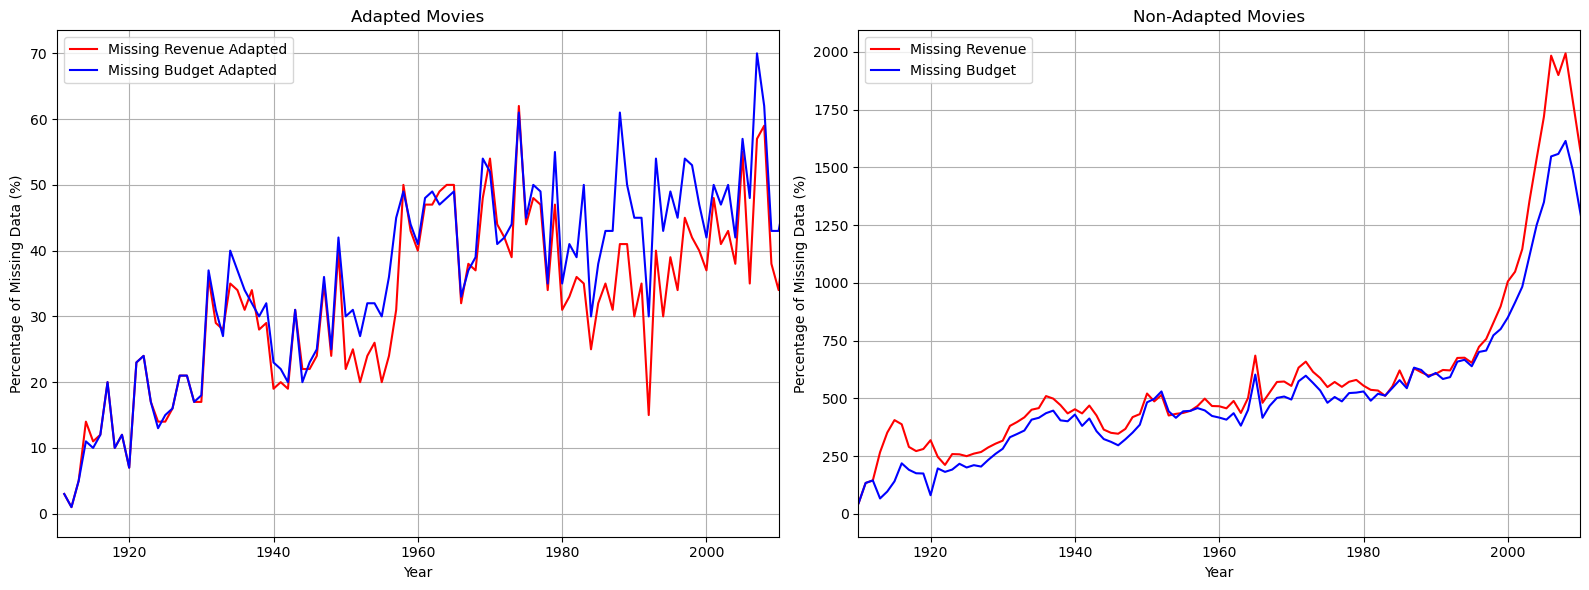

In [228]:
import matplotlib.pyplot as plt 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(missing_revenue_by_year_adapt.index, missing_revenue_by_year_adapt, label='Missing Revenue Adapted', color='red')
ax1.plot(missing_budget_by_year_adapt.index, missing_budget_by_year_adapt, label='Missing Budget Adapted', color='blue')
ax1.set_title('Adapted Movies')
ax1.set_xlabel('Year')
ax1.set_ylabel('Percentage of Missing Data (%)')
ax1.set_xlim([1910, 2010])
ax1.grid(True)
ax1.legend()

ax2.plot(missing_revenue_by_year_non_adapt.index, missing_revenue_by_year_non_adapt, label='Missing Revenue', color='red')
ax2.plot(missing_budget_by_year_non_adapt.index, missing_budget_by_year_non_adapt, label='Missing Budget', color='blue')
ax2.set_title('Non-Adapted Movies')
ax2.set_xlabel('Year')
ax2.set_ylabel('Percentage of Missing Data (%)')
ax2.set_xlim([1910, 2010])
ax2.grid(True)
ax2.legend()

plt.tight_layout()

plt.show()

In [113]:
(book_df
 .merge(goodreads_df, on=['join_title', 'join_author'], how='inner')
 .drop(columns=['join_title', 'join_author'])
 .to_csv("book.csv", index=False)
 )

In [192]:
WIKI_DATA_SERVICE_URL = 'https://query.wikidata.org/sparql'

def get_movie_budget_revenue(ids, retries=5, backoff_factor=1):
    movie_ids = " ".join([f"wd:{id}" for id in ids])
    query = (
            'SELECT ?movie ?movieLabel ?budget ?revenue WHERE { '
            'VALUES ?movie { ' + movie_ids + ' } '  # Make sure movie_ids is correctly formatted
                                             '?movie wdt:P31 wd:Q11424. '
                                             'OPTIONAL { ?movie wdt:P2130 ?budget. } '  # Budget property
                                             'OPTIONAL { ?movie wdt:P2142 ?revenue. } '  # Revenue property
                                             'SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". } '
                                             '}'
    )

    for attempt in range(retries):
        query_result = requests.get(WIKI_DATA_SERVICE_URL, params={'format': 'json', 'query': query})

        if query_result.status_code == 200:
            print("query ok")
            try:
                json_data = query_result.json()
                df = pd.DataFrame(json_data['results']['bindings'])
                for column in df.columns:
                    df[column] = df[column].apply(lambda x: x.get('value') if isinstance(x, dict) else x)
                return df
            except ValueError as e:
                print("Error decoding JSON:", e)
                return pd.DataFrame()  # Return an empty DataFrame if JSON error

        elif query_result.status_code == 429:
            # Exponential backoff
            wait_time = backoff_factor * (2 ** attempt)
            print(f"Rate limited. Retrying in {wait_time} seconds...")
            time.sleep(wait_time)
        else:
            print(f"Request failed with status code {query_result.status_code}")
            return pd.DataFrame()  # Return empty DataFrame if other errors

    print("Max retries reached.")
    return pd.DataFrame()  # Return an empty DataFrame in case of JSON error

In [193]:
book_adaptation_df_query = book_adaptation_df[(book_adaptation_df['movie_revenue'].isna()) | (book_adaptation_df['movie_budget'].isna())]

In [194]:

movie_df_list = []
for i in range(0, len(book_adaptation_df_query), 100):
    ids = book_adaptation_df_query['movie_wikidata_id'][i:i+100]
    movie_df_list.append(get_movie_budget_revenue(ids))
movie_rev_budget = pd.concat(movie_df_list)


query ok
query ok
query ok
query ok
query ok
query ok
query ok
query ok
query ok
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
Rate limited. Retrying in 1 seconds...
query ok
query ok
Rate limited. Retrying in 1 seconds..

In [195]:
movie_rev_budget.head()

,movie,movieLabel,budget,revenue
0,http://www.wikidata.org/entity/Q194106,The City of the Dead,NaN,NaN
1,http://www.wikidata.org/entity/Q226193,33 Scenes from Life,NaN,NaN
2,http://www.wikidata.org/entity/Q245205,The Thirteen Chairs,NaN,NaN
3,http://www.wikidata.org/entity/Q531827,The Fiances,NaN,NaN
4,http://www.wikidata.org/entity/Q535500,Kinjite: Forbidden Subjects,NaN,NaN


In [229]:
test2= (movie_rev_budget['movie_budget'].isnull()).count()
test2

61146

In [196]:
movie_rev_budget['movie'] = movie_rev_budget['movie'].str.replace('http://www.wikidata.org/entity/', '', regex=False)
# Remove the URL prefix to keep only the ID
movie_rev_budget = movie_rev_budget.rename(columns={'movie': 'movie_wikidata_id'})
movie_rev_budget = movie_rev_budget.rename(columns={'budget': 'movie_budget'})
movie_rev_budget = movie_rev_budget.rename(columns={'revenue': 'movie_revenue'})


movie_rev_budget.head()

,movie_wikidata_id,movieLabel,movie_budget,movie_revenue
0,Q194106,The City of the Dead,NaN,NaN
1,Q226193,33 Scenes from Life,NaN,NaN
2,Q245205,The Thirteen Chairs,NaN,NaN
3,Q531827,The Fiances,NaN,NaN
4,Q535500,Kinjite: Forbidden Subjects,NaN,NaN


In [232]:
books_and_movies = pd.merge(book_adaptation_df, movie_rev_budget[['movie_wikidata_id', 'movie_budget', 'movie_revenue']], on='movie_wikidata_id', suffixes=('', '_df2'))
books_and_movies['movie_revenue'] = books_and_movies['movie_revenue'].combine_first(books_and_movies['movie_revenue_df2'])
books_and_movies['movie_budget'] = books_and_movies['movie_budget'].combine_first(books_and_movies['movie_budget_df2'])

books_and_movies= books_and_movies.drop(columns=['movie_revenue_df2', 'movie_budget_df2'])

In [233]:
missing_revenue_count = books_and_movies['movie_revenue'].isna().sum()
print(f"Number of missing values in 'movie_revenue': {missing_revenue_count}")

missing_budget_count = books_and_movies[books_and_movies['movie_is_adaptation'] == 0]['movie_budget'].isna().sum()
print(f"Number of missing values in 'movie_budget': {missing_budget_count}")

Number of missing values in 'movie_revenue': 57025
Number of missing values in 'movie_budget': 55413


In [234]:
missing_revenue_count = book_adaptation_df['movie_revenue'].isna().sum()
print(f"Number of missing values in 'movie_revenue': {missing_revenue_count}")

missing_budget_count = book_adaptation_df[book_adaptation_df['movie_is_adaptation'] == False]['movie_budget'].isna().sum()
print(f"Number of missing values in 'movie_budget': {missing_budget_count}")

Number of missing values in 'movie_revenue': 72161
Number of missing values in 'movie_budget': 60541


In [235]:
books_and_movies.to_csv("books_and_movies.csv", index=False)

In [230]:
missing_revenue_by_year_adapt = proportion_missing_values(books_and_movies, 'movie_revenue', 'movie_release', True)
missing_revenue_by_year_non_adapt = proportion_missing_values(books_and_movies, 'movie_revenue', 'movie_release', False)
missing_budget_by_year_adapt = proportion_missing_values(books_and_movies, 'movie_budget', 'movie_release', True)
missing_budget_by_year_non_adapt = proportion_missing_values(books_and_movies, 'movie_budget', 'movie_release', False)

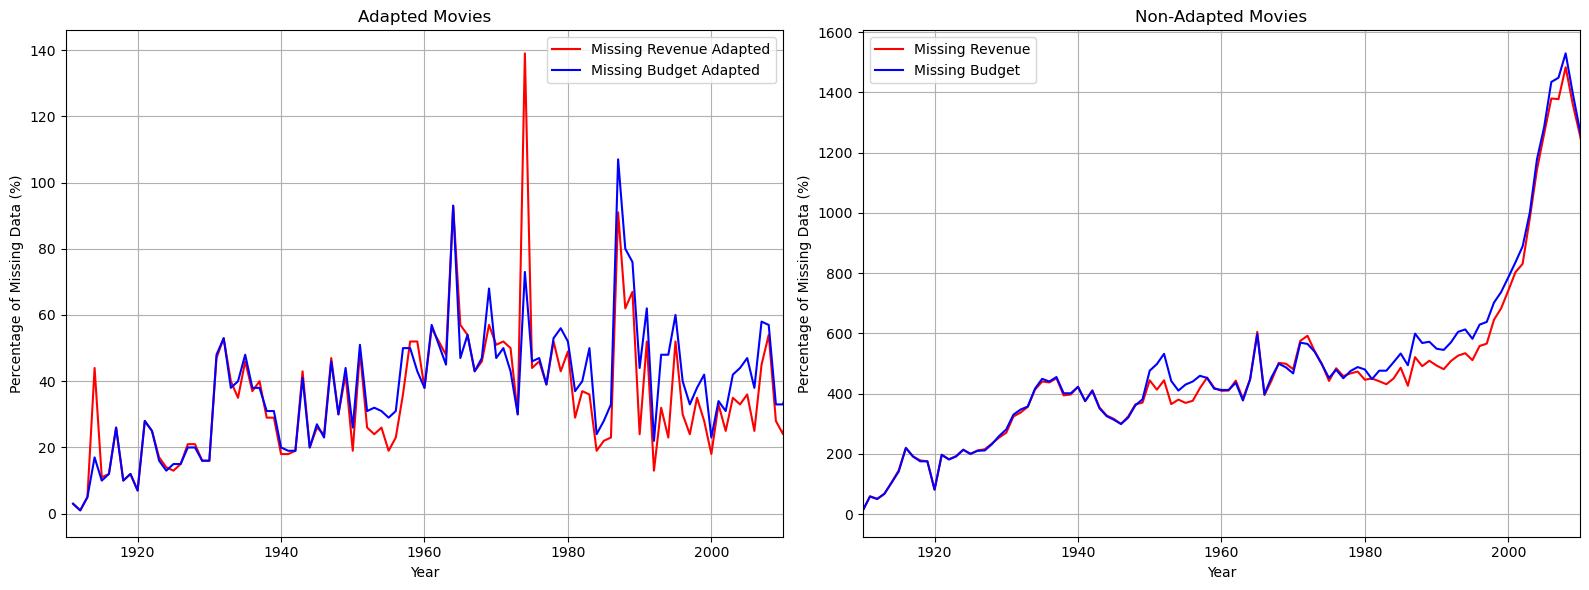

In [231]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(missing_revenue_by_year_adapt.index, missing_revenue_by_year_adapt, label='Missing Revenue Adapted', color='red')
ax1.plot(missing_budget_by_year_adapt.index, missing_budget_by_year_adapt, label='Missing Budget Adapted', color='blue')
ax1.set_title('Adapted Movies')
ax1.set_xlabel('Year')
ax1.set_ylabel('Percentage of Missing Data (%)')
ax1.set_xlim([1910, 2010])
ax1.grid(True)
ax1.legend()

ax2.plot(missing_revenue_by_year_non_adapt.index, missing_revenue_by_year_non_adapt, label='Missing Revenue', color='red')
ax2.plot(missing_budget_by_year_non_adapt.index, missing_budget_by_year_non_adapt, label='Missing Budget', color='blue')
ax2.set_title('Non-Adapted Movies')
ax2.set_xlabel('Year')
ax2.set_ylabel('Percentage of Missing Data (%)')
ax2.set_xlim([1910, 2010])
ax2.grid(True)
ax2.legend()

plt.tight_layout()

plt.show()